In [1]:
import json
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import minimize
import copy

In [3]:
all_data = json.load(open("data.json"))
extracted = []
is_stable = {}
mc = []
for date, data in all_data.items():
    weekly = {"date": date}
    m = {"date": date}
    for coin in data:
        weekly[coin["name"]] = coin["quote"]["USD"]["price"]
        is_stable[coin["name"]] =  "stablecoin" in coin["tags"]
        m[coin["name"]] = coin["quote"]["USD"]["market_cap"]
    extracted.append(weekly)
    mc.append(m)
df  = pd.DataFrame.from_records(extracted)
df['date']= pd.to_datetime(df['date'])
df = df.set_index('date')


market_cap = pd.DataFrame.from_records(mc)
market_cap["date"] = pd.to_datetime(market_cap['date'])
market_cap= market_cap.set_index('date')

delete_list = ["UNUS SED LEO","Revain","Celsius","Nexo", "Bitcoin Diamond","FTX Token","Ethereum Classic","Crypto.com Coin"]

for c in df.columns:
    if is_stable[c] or c in delete_list:
        del df[c]
        del market_cap[c]
print(len(df))

421


In [57]:
for c in df.iloc[-52:].dropna(how="any").columns:
    print(c)

#MetaHash
007Coin
0Chain
0x
12Ships
1CRedit
1inch
1irstcoin
2GIVE
365Coin
42-coin
66 Coin
8Bit
8X8 PROTOCOL
999
ABBC Coin
AIRcoin
ALIS
AMO Coin
APICoin
APIS
APIX
APX
ARBITRAGE
ARCHcoin
ARCoin
ARbit
ATBCoin
ATC Coin
ATMChain
ATOMIC
AXEL
Aave
Abncoin
Acash Coin
Achain
Acoin
AdEx
AdEx Network
Adshares
Advanced Internet Blocks
Advanced Technology Coin
Adzcoin
Aeon
AeroMe
Aeternity
AgaveCoin
Agoras Tokens
Agrello
Aiden
Aidos Kuneen
AimCoin
Aion
AirSwap
AirToken
Akropolis
Akropolis 
Aladdin
Alexium
Algorand
Aliencoin
All Sports
AllSafe
Alpha Finance Lab
Alpha Token
AlphaCoin
Altcoin
AmberCoin
Ambrosus
AmericanCoin
Ampleforth
AmsterdamCoin
AnarchistsPrime
Animecoin
Ankr
Anoncoin
AntiBitcoin
Antilitecoin
Apex
ApexCoin
Aphroditecoin
Apollo Currency
AppCoins
Applecoin
Aragon
Arcade Token
Arcblock
Ardor
Argentum
Aricoin
Ark
ArtByte
Artex Coin
Arweave
AscendEX (BitMax) Token
Ascension
Ascentcoin
Asch
AsiaCoin
Asiadigicoin
AsicCoin
Asset Backed Coin
Aston
Astrocoin
Atlas Protocol
Atmos
Atomic Coin


In [451]:
"Tether" in df.columns

False

In [58]:
last_year_market_cap = market_cap.iloc[-1].dropna()
weight_by_market_cap = np.array(last_year_market_cap / last_year_market_cap.sum())

In [4]:
biggest_by_market_cap = market_cap.iloc[-1].dropna().sort_values(ascending=False)[:40].index
biggest_by_market_cap

Index(['Bitcoin', 'Ethereum', 'Binance Coin', 'Cardano', 'Dogecoin', 'XRP',
       'Polkadot', 'Internet Computer', 'Bitcoin Cash', 'Uniswap', 'Litecoin',
       'Chainlink', 'Stellar', 'Solana', 'VeChain', 'Polygon', 'EOS', 'THETA',
       'TRON', 'Filecoin', 'Monero', 'SHIBA INU', 'Aave', 'Neo', 'Terra',
       'Bitcoin SV', 'Klaytn', 'IOTA', 'Huobi Token', 'Cosmos', 'Tezos',
       'PancakeSwap', 'Avalanche', 'THORChain', 'Kusama', 'Maker', 'Algorand',
       'BitTorrent', 'Compound', 'Dash'],
      dtype='object')

In [95]:
sorted_by_market_cap = market_cap.iloc[-1].dropna().sort_values(ascending=False)[:0]
sorted_by_market_cap / sorted_by_market_cap.sum()

Bitcoin            0.495223
Ethereum           0.206861
Binance Coin       0.046196
Dogecoin           0.033572
Cardano            0.025718
XRP                0.024506
Polkadot           0.017165
Bitcoin Cash       0.012166
Litecoin           0.011728
Chainlink          0.009944
Uniswap            0.009383
VeChain            0.006835
Stellar            0.006591
Solana             0.005495
THETA              0.005434
Filecoin           0.004669
TRON               0.004655
EOS                0.004564
Monero             0.003937
Neo                0.003826
Bitcoin SV         0.003060
Terra              0.002983
PancakeSwap        0.002871
IOTA               0.002860
SHIBA INU          0.002804
Cosmos             0.002758
Aave               0.002609
Tezos              0.002518
Klaytn             0.002404
Maker              0.002390
Huobi Token        0.002317
Polygon            0.002288
Avalanche          0.002286
BitTorrent         0.002204
Algorand           0.002075
Crypto.com Coin    0

In [42]:
a = [1,2,3]
a[:-1]

[1, 2]

In [148]:
date_and_prediction = []

for last_n_weeks in range(-1,-52,-1):
    print(last_n_weeks)
    cut_df = df.iloc[:last_n_weeks]
    date = df.index[last_n_weeks]
    print(cut_df.index[-1])
    print("Prediction timestamp: ", date)

    allocation,sharp = get_weightened_allocation(cut_df,coins=list(biggest_by_market_cap) )
    print("Sharp: ",sharp)
    print(allocation)
    date_and_prediction.append((date,allocation))

-1
2021-05-09 00:00:00
Prediction timestamp:  2021-05-16 00:00:00
-52 None
0.7453871298074951


ValueError: not enough values to unpack (expected 2, got 1)

In [114]:


def get_actual_returns(df, allocations):
    pct_changes = df.pct_change()
    all_returns = []
    for date, a in allocations:
        print(date)
        real_changes = copy.deepcopy(pct_changes.loc[date])
        #print(real_changes)
        #print(real_changes[a.index])
        pct_returns = pd.concat([a,real_changes],axis=1).dropna().cumprod(axis=1).sum().iloc[-1]
        all_returns.append(pct_returns)
    return all_returns


all_returns = get_actual_returns(df, date_and_prediction)

2021-05-16 00:00:00
2021-05-09 00:00:00
2021-05-02 00:00:00
2021-04-25 00:00:00
2021-04-18 00:00:00
2021-04-11 00:00:00
2021-04-04 00:00:00
2021-03-28 00:00:00
2021-03-21 00:00:00
2021-03-14 00:00:00
2021-03-07 00:00:00
2021-02-28 00:00:00
2021-02-21 00:00:00
2021-02-14 00:00:00
2021-02-07 00:00:00
2021-01-31 00:00:00
2021-01-24 00:00:00
2021-01-17 00:00:00
2021-01-10 00:00:00
2021-01-03 00:00:00
2020-12-27 00:00:00
2020-12-20 00:00:00
2020-12-13 00:00:00
2020-12-06 00:00:00
2020-11-29 00:00:00
2020-11-22 00:00:00
2020-11-15 00:00:00
2020-11-08 00:00:00
2020-11-01 00:00:00
2020-10-25 00:00:00
2020-10-18 00:00:00
2020-10-11 00:00:00
2020-10-04 00:00:00
2020-09-27 00:00:00
2020-09-20 00:00:00
2020-09-13 00:00:00
2020-09-06 00:00:00
2020-08-30 00:00:00
2020-08-23 00:00:00
2020-08-16 00:00:00
2020-08-09 00:00:00
2020-08-02 00:00:00
2020-07-26 00:00:00
2020-07-19 00:00:00
2020-07-12 00:00:00
2020-07-05 00:00:00
2020-06-28 00:00:00
2020-06-21 00:00:00
2020-06-14 00:00:00
2020-06-07 00:00:00


/home/cehmann/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [116]:
start = 100
values = [start]
for r in all_returns[::-1]:
    start *= (1+r)
    values.append(start)
plt.plot(values)
plt.show()
    

In [142]:
a = np.array(all_returns)

a.mean() / a.std()

0.42183118399837544

In [137]:

df["Ethereum"].pct_change().iloc[-52:].std()

0.1301750502312479

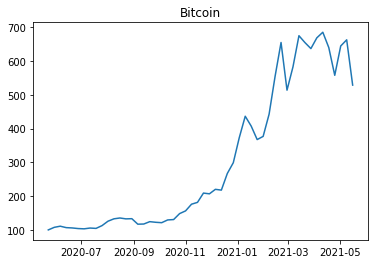

sharp:  0.34684172096640375


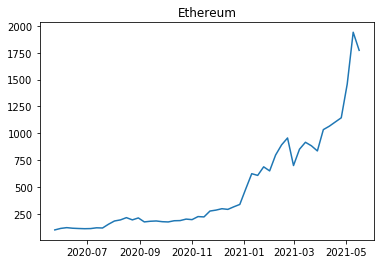

sharp:  0.4920267046188699


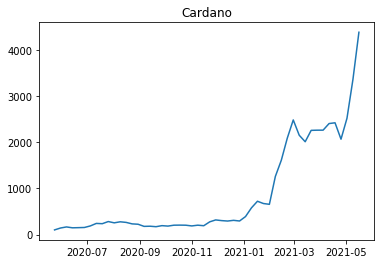

sharp:  0.4555005209070799


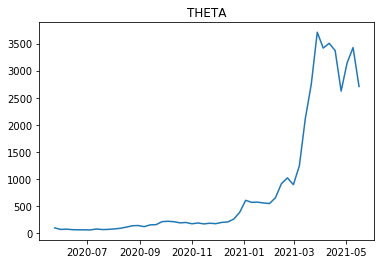

sharp:  0.4345728605317688


In [141]:
pct_changes = df.pct_change()
for coin  in ["Bitcoin","Ethereum","Cardano","THETA"]:
    last_year = df[coin][-52:]
    pct_coin = pct_changes[coin].iloc[-52:]
    plt.plot( last_year * 100 / last_year[0]  )
    plt.title(coin)
    plt.show()
    print("sharp: " , pct_coin.mean() / pct_coin.std() )
    
    
    

In [436]:
annual_returns, annual_cov = get_annual_returns_and_covariances(df, -52, None, drop_na=False, coins=list(last_year_market_cap.index))


r,v = get_returns_and_volatility(annual_returns,weight_by_market_cap, annual_cov)

print("Returns: ", r, "Volatility: ", v)

print(get_allocation(weight_by_market_cap, annual_returns))

Returns:  2.286860904349846 Volatility:  4.805880916559545
              allocation
Binance Coin         1.0
Bitcoin             67.0
Bitcoin Cash         2.0
Bitcoin SV           1.0
Cardano              1.0
EOS                  1.0
Ethereum             9.0
Litecoin             1.0
Stellar              1.0
Tether               3.0
Tezos                1.0
XRP                  3.0


In [7]:


def get_annual_returns_and_covariances(df, start_index, end_index,drop_na=True,coins=None):
      
    if end_index:
        timeframe = df.iloc[start_index:end_index]
    else:
        timeframe = df.iloc[start_index:]
    if coins:
        for c in timeframe.columns:
            if c not in coins:
                del timeframe[c]
    if drop_na:
        timeframe = timeframe.dropna(axis=1, how="any")
    returns_weekly = timeframe.pct_change()
    returns_annual = returns_weekly.mean() * len(timeframe)
    cov_weekly = returns_weekly.cov()
    cov_annual = cov_weekly * len(timeframe)
    return returns_annual,cov_annual

In [8]:

def calculate_best_portfolio_for_timeframe(df, start_index, end_index=None):
    
    annual_returns, annual_cov = get_annual_returns_and_covariances(df, start_index, end_index)
    weights = maxSR(annual_returns, annual_cov).x
    r,v = get_returns_and_volatility(annual_returns, weights, annual_cov)
    allocation = get_allocation(weights,annual_returns)
    print(allocation)


In [9]:
def calculate_efficient_frontier_for_timeframe(df, start_index, end_index=None):
    
    
    annual_returns, annual_cov = get_annual_returns_and_covariances(df, start_index, end_index)
    efficient_weights = get_efficient_weights(annual_returns, annual_cov)
    
    max_sharp_allocation = None
    sharp = -np.inf
    for weights in efficient_weights:
        r,v = get_returns_and_volatility(annual_returns, weights, annual_cov)
        allocation = get_allocation(weights,annual_returns)
        if r/v > sharp:
            sharp = r/v
            max_sharp_allocation = allocation
        #print(allocation)
    return sharp, max_sharp_allocation


In [143]:

def get_max_sharp_allocations(df, start_and_end):
    
    max_sharp_allocations = []
    sharps = []
    for start,end in start_and_end:
        print(start,end)
        sharp,allocation = calculate_efficient_frontier_for_timeframe(df, start,end_index=end)
        max_sharp_allocations.append(allocation)
        sharps.append(sharp)
    return max_sharp_allocations, sharps

In [147]:


def get_weightened_allocation(df,coins=[]):
    
    if coins:
        for c in df.columns:
            if c not in coins:
                del df[c]

    max_sharp_allocations, sharps = get_max_sharp_allocations(df,[(-52,None)] )
    print(sharps)
    weights = [1]
    weighted_allocations = [ m*w for m,w in zip(max_sharp_allocations, weights)]
    summed = pd.concat(weighted_allocations, axis=1).sum(axis=1) 
    normed =   summed / summed.sum()
    below_1_percent = normed[normed >= 0.01] 
    renormed = below_1_percent / below_1_percent.sum()
    return renormed, sharps[0]


420
-52 None
Cardano     0.063055
Chiliz      0.021454
Dogecoin    0.049466
Ethereum    0.196785
Monero      0.117879
NEM         0.227501
THETA       0.199178
Terra       0.027568
VeChain     0.025978
Waves       0.071135
dtype: float64
-12
-52 None
Cardano      0.032223
Chainlink    0.080569
Dogecoin     0.064955
FTX Token    0.187794
NEM          0.238528
THETA        0.264112
Waves        0.131818
dtype: float64
-24
-52 None
Cardano      0.048779
Chainlink    0.048308
FTX Token    0.260285
NEM          0.228382
THETA        0.203546
Waves        0.210699
dtype: float64
-36
-52 None
Chainlink          0.171697
Crypto.com Coin    0.289525
FTX Token          0.441817
THETA              0.062519
VeChain            0.034442
dtype: float64
-48
-52 None
Chainlink    0.396580
THETA        0.286612
Tezos        0.316807
dtype: float64


In [44]:
print(get_weightened_allocation(df.iloc[:-12]))

-52 None
-36 None
-12 None
ABBC Coin        0.087153
Dogecoin         0.017868
FTX Token        0.043398
Kyber Network    0.051943
NEM              0.105552
PAX Gold         0.340809
Quant            0.088596
Ren              0.013048
THETA            0.098847
Velas            0.093541
Waves            0.026169
Zilliqa          0.033075
dtype: float64


/home/cehmann/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [530]:
percent_market_cap = [ m for c,m in c_m  ]

percent_market_cap / sum(percent_market_cap)

array([1.32612695e-03, 2.49748733e-03, 1.22400390e-01, 7.54194643e-01,
       2.66095881e-03, 4.93944162e-04, 6.33117407e-03, 6.04415557e-04,
       1.43531041e-02, 5.61808703e-03, 3.59541128e-03, 7.70807147e-04,
       2.00338681e-02, 1.98109450e-02, 7.11765223e-03, 3.38196446e-03,
       2.49207044e-02, 5.50766833e-03, 4.38064805e-03])

In [24]:

def get_returns_and_volatility( returns_annual, weights, covariance ):
    
    returns = weights @ returns_annual
    volatility = np.sqrt(weights.T @ (covariance @ weights)) * np.sqrt(52)
    return returns, volatility



def get_allocation(weights, meanReturns):
    allocation = pd.DataFrame(weights, index=copy.deepcopy(meanReturns.index), columns=['allocation'])
    #allocation["allocation"]  = [round(i*100,0) for i in allocation["allocation"]]    
    return allocation[allocation ["allocation"] >= 0.001]


def get_random_weights(n):
    
    weights = np.random.random(n)
    weights /= np.sum(weights)    
    return weights



def negative_return(weights,returns_annual, covariance):
    r,v = get_returns_and_volatility( returns_annual, weights, covariance )
    return -r

def positive_return(weights,returns_annual, covariance):
    r,v = get_returns_and_volatility( returns_annual, weights, covariance )
    return r


def volatility(weights,returns_annual,covariance):
    
    r,v = get_returns_and_volatility( returns_annual, weights, covariance )
    return v


# risk free rate from germany https://www.statista.com/statistics/885915/average-risk-free-rate-select-countries-europe/
def sharp_ratio(r,v, risk_free_rate=0.008 ):
    return (r - risk_free_rate) / v 

def negative_sharp_ratio(r,v,risk_free_rate=0.008):
    
    return -sharp_ratio(r,v,risk_free_rate=risk_free_rate
                       )
# need to put weights in front for optimizer
def negative_sharp_of_portfolio(weights,returns_annual, covariance, risk_free_rate):
    r,v = get_returns_and_volatility(returns_annual, weights, covariance)
    return negative_sharp_ratio(r,v,risk_free_rate=risk_free_rate)
    

In [280]:
get_returns_and_volatility( returns_annual,  np.ones(75)/75, cov_annual)

(3.694917032049072, 7.137696011739017)

In [275]:

# sample weights and plot
all_weights = []
all_returns = []
all_volatilities = []
all_sharp = []
for _ in range(100000):
    
    weights = get_random_weights(len(returns_annual))
    returns,volatility = get_returns_and_volatility(returns_annual, weights,cov_annual)
    all_weights.append(weights)
    all_returns.append(returns)
    all_volatilities.append(volatility)
    all_sharp.append(sharp_ratio(returns,volatility))

    


In [84]:
max_sharp_index = np.array(all_sharp).argmax()
max_weights = all_weights[max_sharp_index]

In [85]:
for c,w in zip(last_year.columns,max_weights):
    if w > 0.001:Bitcoin           14.0
Celsius           14.0
Chainlink          4.0
Dogecoin           1.0
Enjin Coin         1.0
Monero            25.0
NEM               14.0
Nexo               8.0
Numeraire          1.0
Quant             11.0
        print (c,w)

Algorand 0.003349785728448174
Aragon 0.003652106271136682
Ardor 0.015186819008627957
Augur 0.010090139819632353
Basic Attention Token 0.014102957299243575
Binance Coin 0.003583147270267668
Binance USD 0.016426438782395008
BitShares 0.005863856480811021
BitTorrent 0.012472455907149555
Bitcoin 0.016922269035245557
Bitcoin Cash 0.020246538656275098
Bitcoin Diamond 0.0035805588864244254
Bitcoin Gold 0.013878959128626458
Bitcoin SV 0.010622532970582927
Cardano 0.015850474937518136
Celsius 0.020977704270411946
Chainlink 0.02318078646521234
Chiliz 0.015428831568849463
Cosmos 0.023384861479331318
Dash 0.0020105450293566203
Decentraland 0.019533261442998023
Decred 0.003042467309607576
DigiByte 0.01468491533896374
Dogecoin 0.023646907999450392
EOS 0.015778685924467538
Enjin Coin 0.014452877181327506
Ethereum 0.023250201350361502
Ethereum Classic 0.014360200419263688
FTX Token 0.0025383096684963202
Golem 0.005721923128429793
HUSD 0.0185528002951007
Hedera Hashgraph 0.010813451373072122
Holo 0.003

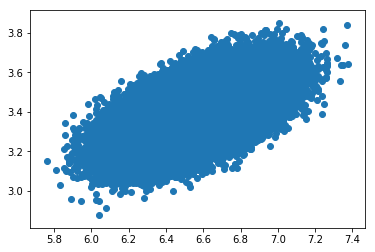

In [79]:
plt.scatter(all_volatilities,all_returns)
plt.show()

In [13]:
def maxSR(meanReturns, covMatrix, riskFreeRate = 0.008, constraintSet=(0,1)):
    "Minimize the negative SR, by altering the weights of the portfolio"
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    result = minimize(negative_sharp_of_portfolio, numAssets*[1./numAssets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [14]:
def minimizeVariance(meanReturns, covMatrix, riskFreeRate = 0.008, constraintSet=(0,1)):
    "Minimize the negative SR, by altering the weights of the portfolio"
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    result = minimize(volatility, numAssets*[1./numAssets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [17]:
def maxReturn(meanReturns, covMatrix, riskFreeRate = 0.008, constraintSet=(0,1)):
    "Minimize the negative SR, by altering the weights of the portfolio"
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    result = minimize(negative_return, numAssets*[1./numAssets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [19]:
def efficientOpt(meanReturns, covMatrix, returnTarget, constraintSet=(0,1)):
    """For each returnTarget, we want to optimise the portfolio for min variance"""
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)

    constraints = ({'type':'eq', 'fun': lambda x: positive_return(x, meanReturns, covMatrix) - returnTarget},
                    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    effOpt = minimize(volatility, numAssets*[1./numAssets], args=args, method = 'SLSQP', bounds=bounds, constraints=constraints)
    return effOpt

In [20]:
def calculatedResults(meanReturns, covMatrix):
    """Read in mean, cov matrix, and other financial information
        Output, Max SR , Min Volatility, efficient frontier """
    # Max Return Ratio Portfolio
    maxSR_Portfolio = maxReturn(meanReturns, covMatrix)
    maxSR_returns, maxSR_std = get_returns_and_volatility(meanReturns,maxSR_Portfolio['x'], covMatrix)
    #maxSR_returns, maxSR_std = round(maxSR_returns*100,2), round(maxSR_std*100,2)
    maxSR_allocation = get_allocation(maxSR_Portfolio['x'], meanReturns)
    print("Max return:", maxSR_returns, maxSR_std)

    # Min Volatility Portfolio
    minVol_Portfolio = minimizeVariance(meanReturns, covMatrix)
    minVol_returns, minVol_std = get_returns_and_volatility(meanReturns,minVol_Portfolio['x'], covMatrix)
    #minVol_returns, minVol_std = round(minVol_returns*100,2), round(minVol_std*100,2)
    minVol_allocation = pd.DataFrame(minVol_Portfolio['x'], index=meanReturns.index, columns=['allocation'])
    minVol_allocation.allocation = [round(i*100,0) for i in minVol_allocation.allocation]

    print("MIn vol:", minVol_returns, minVol_std)
    # Efficient Frontier
    efficientList = []
    targetReturns = np.linspace(minVol_returns, maxSR_returns, 20)
    print(targetReturns)
    for target in targetReturns:
        efficientList.append(efficientOpt(meanReturns, covMatrix, target))

    return maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, targetReturns, efficientList







In [21]:
def get_efficient_weights(meanReturns, covMatrix):
    """Read in mean, cov matrix, and other financial information
        Output, Max SR , Min Volatility, efficient frontier """
    # Max Return Ratio Portfolio
    maxSR_Portfolio = maxReturn(meanReturns, covMatrix)
    maxSR_returns, maxSR_std = get_returns_and_volatility(meanReturns,maxSR_Portfolio['x'], covMatrix)
    #maxSR_returns, maxSR_std = round(maxSR_returns*100,2), round(maxSR_std*100,2)
    maxSR_allocation = get_allocation(maxSR_Portfolio['x'], meanReturns)

    # Min Volatility Portfolio
    minVol_Portfolio = minimizeVariance(meanReturns, covMatrix)
    minVol_returns, minVol_std = get_returns_and_volatility(meanReturns,minVol_Portfolio['x'], covMatrix)
    #minVol_returns, minVol_std = round(minVol_returns*100,2), round(minVol_std*100,2)
    minVol_allocation = pd.DataFrame(minVol_Portfolio['x'], index=meanReturns.index, columns=['allocation'])
    minVol_allocation.allocation = [round(i*100,0) for i in minVol_allocation.allocation]

    # Efficient Frontier
    efficientList = []
    targetReturns = np.linspace(minVol_returns, maxSR_returns, 20)
    for target in targetReturns:
        efficientList.append(efficientOpt(meanReturns, covMatrix, target))

    return  [ e.x for e in efficientList]







In [ ]:
#simulate Bitcoin by sampling from the return
import numpy as np


bitcoin_weekly = np.array(returns_weekly["Bitcoin"].iloc[1:])

all_samples = []

for _ in range(1000):
    val = 100
    for i in range(51):    
        val *= 1 + bitcoin_weekly[np.random.randint(0,len(bitcoin_weekly))]

    all_samples.append(val)
print(np.mean(all_samples))
